In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import tensorflow as tf
from collections import Counter

%matplotlib inline

/home/samuel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Imports

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
race = "hispanic"
#race = "white"
#race = "mixed"

In [4]:
X = np.load('../Data/' + race + '/X.npy')
Y2 = np.load('../Data/' + race + '/Y2.npy')

In [5]:
def split_train_test(X, Y):
    # shuffle
    np.random.seed(42)
    idx = np.random.permutation(len(X))
    X = X[idx]
    Y = Y[idx]
    
    #X = X[:size_hispanic]
    #Y = Y[:size_hispanic]

    # split into training and test sets
    TEST_SET_SIZE = int(0.1*len(Y))
    X_train, X_test = X[:-TEST_SET_SIZE], X[-TEST_SET_SIZE:]
    Y_train, Y_test = Y[:-TEST_SET_SIZE].astype(int), Y[-TEST_SET_SIZE:].astype(int)
    return X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test = split_train_test(X, Y2)

In [6]:
X_train.shape

(33818, 301)

# Feature Scaling
Fit scaler based on training data, then transform both the training and test data.

In [7]:
# feature scaling: scale features based on training data only
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def feature_scale(X_train, X_test):
    
    mm_scaler = MinMaxScaler(feature_range=(-1,1))
    X_train[:,:-4] = mm_scaler.fit_transform(X_train[:,:-4])
    X_test[:,:-4] = mm_scaler.transform(X_test[:,:-4])
    
    std_scaler = StandardScaler()
    X_train[:,-4:] = std_scaler.fit_transform(X_train[:,-4:])
    X_test[:,-4:] = std_scaler.transform(X_test[:,-4:])
    return X_train, X_test
    
    #mm_scaler = MinMaxScaler(feature_range=(-1,1))
    #X_train[:,-4:] = mm_scaler.fit_transform(X_train[:,-4:])
    #X_test[:,-4:] = mm_scaler.transform(X_test[:,-4:])
    
    #std_scaler = StandardScaler()
    #X_train[:,:-4] = std_scaler.fit_transform(X_train[:,:-4])
    #X_test[:,:-4] = std_scaler.transform(X_test[:,:-4])
    #return X_train, X_test

X_train, X_test = feature_scale(X_train, X_test)

/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Results Function

In [8]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

def results(classifier, X_test=X_test):
    #Y_pred_test = classifier.predict(X_test)
    Y_pred_test = classifier.predict(X_test)
    print("Test accuracy score: " + str(accuracy_score(Y_test.astype(int), Y_pred_test)))
    print("ROC: " + str(roc_auc_score(Y_test, classifier.predict_proba(X_test)[:,1])))
    #print("ROC: " + str(roc_auc_score(Y_test, Y_pred_test)))
    matrix = confusion_matrix(Y_test.astype(int), Y_pred_test)
    tn, fp, fn, tp = matrix.ravel()
    ppv = tp/(tp+fp)
    npv = tn/(tn+fn)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    g_mean = np.sqrt(sensitivity*specificity)
    print("PPV: " + str(ppv))
    print("NPV: " + str(npv))
    print("Sensitivity: " + str(sensitivity))
    print("Specificity: " + str(specificity))
    print("G-Mean: " + str(g_mean))
    print("Confusion matrix:\n" + str(matrix))
    

In [49]:
import pickle
with open('white_codes.pkl', 'rb') as f_w:
    white_codes = pickle.load(f_w)
with open('hispanic_codes.pkl', 'rb') as f_h:
    hispanic_codes = pickle.load(f_h)
with open('mixed_codes.pkl', 'rb')  as f_m:
    mixed_codes = pickle.load(f_m)

In [48]:
def feature_importance_rank(array):
    codes = None
    if race == "white":
        codes = white_codes
    elif race == "hispanic":
        codes = hispanic_codes
    elif race == "mixed":
        codes = mixed_codes
        
    array = np.abs(array)
    
    ranking = {}
    ranking['tumsiz'] = array[-1]
    ranking['maligcount'] = array[-2]
    ranking['eod10_pn'] = array[-3]
    ranking['age_dx'] = array[-4]
    
    for key, val in codes.items():
        varname = key[1]
        start_idx = key[2]
        end_idx = start_idx + len(val)
        ranking[varname] = np.sum(array[start_idx:end_idx])
    
    d_view = [(name, score) for name,score in ranking.items()]
    d_view.sort(key=lambda x:x[1], reverse=True)
    for rank, pair in enumerate(d_view, 1):
        print(rank, pair)
    

In [58]:
race

'hispanic'

## Decision Tree

In [ ]:

# min_sample_split: 300,400
# min_samples_leaf: 200
# max_depth: 130
# min_weight_fraction_leaf: .01
param_grid = [{'max_depth':[40,50,60], 'min_samples_leaf':[250,260,270,280,290]}]
tree_clf_reg = DecisionTreeClassifier()
dt_grid_search = GridSearchCV(tree_clf_reg, param_grid, cv=3, scoring=make_scorer(roc_auc_score), verbose=3)
dt_grid_search.fit(X_train, Y_train.astype(int))

In [ ]:
cvres = dt_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)
print("Best: " + str(dt_grid_search.best_params_))

In [ ]:
results(dt_grid_search, X_test, Y_test)

In [ ]:
tree_clf_h = DecisionTreeClassifier(max_features=200, min_samples_leaf=150)
tree_clf_h.fit(X_train, Y_train)


In [ ]:
results(tree_clf_h, X_test, Y_test)

In [ ]:
feature_importance_rank(tree_clf_h.feature_importances_)

In [ ]:
sorted(enumerate(tree_clf_h.feature_importances_), key=lambda x:x[1], reverse=True)

## K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, Y_train.astype(int))

In [ ]:
results(knn_clf)

## Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
param_grid = [{'C':[.01, .1, .75, 1, 1.5, 2]}]
lr_grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3, 
                              scoring=make_scorer(roc_auc_score), verbose=5
                             )
lr_grid_search.fit(X_train, Y_train.astype(int))

In [ ]:
cvres = lr_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)
print("Best: " + str(lr_grid_search.best_params_))

In [ ]:
results(lr_grid_search)

In [17]:
# class_weight={1:1, 0:2}
lr = LogisticRegression(C=1)
lr.fit(X_train_res, Y_train_res.astype(int))
#lr.fit(X_train, Y_train.astype(int))
results(lr)

Test accuracy score: 0.7859994676603673
ROC: 0.8621116626152943
PPV: 0.9392774788624135
NPV: 0.4406926406926407
Sensitivity: 0.7909385113268609
Specificity: 0.7631184407796102
G-Mean: 0.7769039602912964
Confusion matrix:
[[ 509  158]
 [ 646 2444]]


In [51]:
feature_importance_rank(lr.coef_[0])

1 ('histo3v', 96.06255826332563)
2 ('cslymphn', 25.57801927708296)
3 ('csexten', 22.994834502017223)
4 ('surgprif', 13.530888430157434)
5 ('csmetsdx', 7.281425159591815)
6 ('dx_conf', 7.057789032407945)
7 ('no_surg', 1.4832789203341878)
8 ('primsite', 1.2447061891246762)
9 ('summ2k', 0.9112371113004079)
10 ('reg', 0.7349946965039462)
11 ('csrgeval', 0.6808676684096703)
12 ('csmteval', 0.5873336906383287)
13 ('age_dx', 0.5858548689413616)
14 ('grade', 0.5565595791808087)
15 ('mar_stat', 0.4956490969463544)
16 ('cstseval', 0.43000020025116614)
17 ('eod10_pn', 0.37645871245648516)
18 ('beho3v', 0.3170906665926988)
19 ('tumsiz', 0.09472825437103119)
20 ('sex', 0.08505543770586206)
21 ('maligcount', 0.018261461444274315)


In [39]:
for key, val in enumerate(lr.coef_[0]):
    print(key, val)

0 -0.05737697073777099
1 0.034081608052809305
2 -0.05772787551449055
3 -0.06030471897979592
4 -0.05322176342373494
5 0.03784303999854836
6 0.09327584825525215
7 0.050007374981851684
8 -0.07919235184652058
9 0.24544618182879085
10 -0.04102900592776424
11 -0.07742918766640221
12 -0.09088765498982207
13 -0.0591072158469683
14 -0.06721070667018697
15 0.020042280401000912
16 -0.11485471259687782
17 0.018630336788553952
18 -0.058855853395692534
19 0.020581389903585903
20 0.14431866884314906
21 -0.5497503445430474
22 -0.012686166475178179
23 -0.43829196280586513
24 -0.09863556406214125
25 -1.4046934853459874
26 -0.9305335449850675
27 -0.012686166475178179
28 -0.04043259287881241
29 0.7455695283438797
30 -0.9615955827727058
31 -0.39172951927389676
32 -0.8357772471151096
33 -0.0023464388686222095
34 -0.32741340594896373
35 1.8529960748133631
36 0.5979626383218951
37 0.12380717943897646
38 0.001636163882496957
39 0.28870767350396637
40 2.1099413505184628
41 -0.4117614861202147
42 0.0844695039293

In [42]:
sorted(enumerate(lr.coef_[0]), key=lambda x:x[1], reverse=True)

[(108, 2.3714656306113038),
 (40, 2.1099413505184628),
 (35, 1.8529960748133631),
 (83, 1.6124822037176623),
 (269, 1.5987993136999672),
 (123, 1.3907044660609802),
 (87, 1.2696219454993165),
 (71, 1.0283118207284778),
 (50, 0.9923404692470302),
 (74, 0.9708234605456145),
 (82, 0.8610047465467753),
 (89, 0.8340592366795428),
 (29, 0.7455695283438797),
 (124, 0.7368513083282134),
 (91, 0.6970567081631824),
 (36, 0.5979626383218951),
 (116, 0.5977329031083224),
 (84, 0.5880822072589293),
 (239, 0.5673352168499558),
 (247, 0.5670260606463017),
 (117, 0.5569134542022844),
 (195, 0.5462654899230934),
 (127, 0.5057037612323629),
 (125, 0.4832824359715561),
 (200, 0.47205000351128484),
 (288, 0.47022745559792734),
 (115, 0.44040977003409065),
 (177, 0.4399287026535692),
 (59, 0.41738169373172573),
 (235, 0.40992756356136273),
 (121, 0.3941273770301414),
 (168, 0.38945782141352714),
 (237, 0.38568102952782757),
 (187, 0.3665353072580656),
 (199, 0.3628044838454373),
 (178, 0.3483356709513902),

## Random Forest

In [ ]:
#scoring=make_scorer(roc_auc_score)
param_grid = [{'max_features':[175,200], 'n_estimators':[10,15,20], 'min_samples_leaf':[150,175,200]}]
rf_grid_search = GridSearchCV(RandomForestClassifier(), 
            param_grid, cv=3, scoring=make_scorer(roc_auc_score), 
            verbose=5
)
rf_grid_search.fit(X_train_res, Y_train_res)

In [ ]:
cvres = rf_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)
print("Best: " + str(rf_grid_search.best_params_))

In [18]:
Counter(Y_train_res)

Counter({0: 27723, 1: 27723})

In [19]:
# class_weight={1:1,0:3}
rf_clf = RandomForestClassifier(n_estimators=20, min_samples_leaf=150, max_features=200, random_state=42)
rf_clf.fit(X_train_res, Y_train_res)
results(rf_clf)

Test accuracy score: 0.8035666755389939
ROC: 0.8595372216804219
PPV: 0.9381520119225037
NPV: 0.46691519105312207
Sensitivity: 0.8148867313915857
Specificity: 0.7511244377811095
G-Mean: 0.7823562730443151
Confusion matrix:
[[ 501  166]
 [ 572 2518]]


In [99]:
feature_importance_rank(rf_clf.feature_importances_)

1 ('csmetsdx', 0.3889737599586425)
2 ('summ2k', 0.2119298921160748)
3 ('age_dx', 0.08708194288580808)
4 ('no_surg', 0.08474243849871409)
5 ('eod10_pn', 0.0742133772951314)
6 ('surgprif', 0.0528253895311063)
7 ('tumsiz', 0.03281095280458478)
8 ('grade', 0.017621186775247075)
9 ('primsite', 0.0074967519415122755)
10 ('csexten', 0.007282790887804617)
11 ('mar_stat', 0.00681587596495206)
12 ('histo3v', 0.0055414588290072075)
13 ('dx_conf', 0.005274295242352326)
14 ('cslymphn', 0.005241316965868953)
15 ('maligcount', 0.004177950923072821)
16 ('sex', 0.0021267599879958013)
17 ('reg', 0.0016841953973572982)
18 ('csmteval', 0.0015940421256534537)
19 ('beho3v', 0.0012904150078187596)
20 ('cstseval', 0.0011654497314790646)
21 ('csrgeval', 0.0010737627260390672)


In [ ]:
sorted(enumerate(rf_clf.feature_importances_), key=lambda x:x[1], reverse=True)

In [ ]:
results(rf_grid_search, X_test, Y_test)

## Linear SVM

In [62]:
from sklearn.svm import LinearSVC
svm_clf = LinearSVC(C=.01)
svm_clf.fit(X_train, Y_train)

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [67]:
results(svm_clf)

Test accuracy score: 0.8521014307613695
ROC: 0.7031383223351095
PPV: 0.8799617055747846
NPV: 0.6699566682715455
Sensitivity: 0.9457437967470023
Specificity: 0.46053284792321697
G-Mean: 0.6599591533736107
Confusion matrix:
[[ 2783  3260]
 [ 1371 23898]]


In [65]:
feature_importance_rank(svm_clf.coef_[0])

1 ('histo3v', 9.196570515231087)
2 ('cslymphn', 4.173764301426509)
3 ('csexten', 3.431019655582666)
4 ('csmetsdx', 1.7683391128567432)
5 ('surgprif', 1.023685329861967)
6 ('primsite', 0.49641579672149716)
7 ('no_surg', 0.45462887016807974)
8 ('csmteval', 0.383803137445053)
9 ('reg', 0.3450647045112549)
10 ('dx_conf', 0.3355456127906983)
11 ('summ2k', 0.2197410222547135)
12 ('grade', 0.16209525477515435)
13 ('age_dx', 0.1380847916237922)
14 ('mar_stat', 0.1191835444475507)
15 ('cstseval', 0.10887718026656777)
16 ('csrgeval', 0.10383574812886044)
17 ('beho3v', 0.09099250071731302)
18 ('eod10_pn', 0.08383812366116374)
19 ('sex', 0.03243497295414094)
20 ('maligcount', 0.01958078722576911)
21 ('tumsiz', 0.01718338686161156)


In [ ]:
sorted(enumerate(svm_clf.coef_[0]), key=lambda x:x[1], reverse=True)

# Ensemble

In [42]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
clf1 = RandomForestClassifier(n_estimators=20, min_samples_leaf=300, max_features=225)
clf2 = LogisticRegression(C=1)
clf3 = GaussianNB()
clf4 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=20, 
                           algorithm="SAMME.R", learning_rate=1)

eclf = VotingClassifier(estimators=[
    ('rf', clf1), ('lr', clf2), ('ab', clf4)
], voting='soft')
eclf.fit(X_train, Y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=225, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=300, min_samples_split=2,
            min_wei...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [43]:
results(eclf)

Test accuracy score: 0.8581314878892734
ROC: 0.8677830987418913
PPV: 0.8870723584620043
NPV: 0.6475770925110133
Sensitivity: 0.948220064724919
Specificity: 0.4407796101949025
G-Mean: 0.6464952207931897
Confusion matrix:
[[ 294  373]
 [ 160 2930]]


/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=50, max_samples=3000,
                           bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train_res, Y_train_res)

In [ ]:
results(bag_clf)

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier
bbc = BalancedBaggingClassifier(DecisionTreeClassifier(), n_estimators=200, max_samples=3000,
                           bootstrap=True, n_jobs=-1)
bbc.fit(X_train, Y_train)

In [ ]:
results(bbc)

# AdaBoost

In [ ]:
#scoring=make_scorer(roc_auc_score)
param_grid = [{"n_estimators":[100, 115, 130, 145], "learning_rate":[.6, .7, .8, .9, 1]}]
ab_grid_search = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME.R"), 
            param_grid, cv=3, scoring=make_scorer(roc_auc_score), 
            verbose=5
)
ab_grid_search.fit(X_train, Y_train)

In [ ]:
cvres = ab_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)
print("Best: " + str(ab_grid_search.best_params_))

In [ ]:
results(ab_grid_search)

In [49]:
ab_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, 
                           algorithm="SAMME.R", learning_rate=1)
ab_clf.fit(X_train_res, Y_train_res)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=200, random_state=None)

In [50]:
results(ab_clf)

Test accuracy score: 0.8090658343616172
ROC: 0.8708224251054344
PPV: 0.9391394504924832
NPV: 0.5054453049370765
Sensitivity: 0.8159257757960636
Specificity: 0.7806017566809942
G-Mean: 0.7980683516514799
Confusion matrix:
[[ 4177  1174]
 [ 4087 18116]]


In [70]:
feature_importance_rank(ab_clf.feature_importances_)

1 ('csexten', 0.18)
2 ('age_dx', 0.125)
3 ('eod10_pn', 0.1)
4 ('histo3v', 0.1)
5 ('csmetsdx', 0.085)
6 ('tumsiz', 0.08)
7 ('surgprif', 0.065)
8 ('primsite', 0.04)
9 ('summ2k', 0.039999999999999994)
10 ('reg', 0.035)
11 ('grade', 0.030000000000000002)
12 ('mar_stat', 0.02)
13 ('dx_conf', 0.02)
14 ('no_surg', 0.02)
15 ('cslymphn', 0.015)
16 ('cstseval', 0.015)
17 ('csrgeval', 0.015)
18 ('beho3v', 0.01)
19 ('sex', 0.005)
20 ('csmteval', 0.005)
21 ('maligcount', 0.0)


## Gradient Boosted Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=400)
gb_clf.fit(X_train_res, Y_train_res)

In [ ]:
results(gb_clf)

# SMOTE

In [16]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(ratio={0: 27723, 1:27723},random_state=42)
X_train_res, Y_train_res = sm.fit_sample(X_train,Y_train)

In [ ]:
Counter(Y_train_res)

In [15]:
Counter(Y_train)

Counter({0: 6095, 1: 27723})

# Undersampling

In [47]:
from imblearn.under_sampling import RandomUnderSampler
us = RandomUnderSampler(ratio={0:Counter(Y_train)[0], 1:Counter(Y_train)[0]})
X_train_res, Y_train_res = us.fit_sample(X_train, Y_train)

In [48]:
Counter(Y_train_res)

Counter({0: 47992, 1: 47992})

# Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(ratio={0:20000, 1:27731})
X_train_res, Y_train_res = os.fit_sample(X_train, Y_train)

## t-SNE

In [9]:
from sklearn.manifold import TSNE

In [82]:
tsne = TSNE(n_components=2, init='pca', random_state=97, verbose=5)
size = 2000
X_tsne = tsne.fit_transform(X[:size])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.017s...
[t-SNE] Computed neighbors for 2000 samples in 0.595s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 3.305405
[t-SNE] Computed conditional probabilities in 0.095s
[t-SNE] Iteration 50: error = 48.5721245, gradient norm = 0.0548753 (50 iterations in 2.221s)
[t-SNE] Iteration 100: error = 49.8698463, gradient norm = 0.0553123 (50 iterations in 1.760s)
[t-SNE] Iteration 150: error = 50.6148109, gradient norm = 0.0556829 (50 iterations in 1.782s)
[t-SNE] Iteration 200: error = 52.1643791, gradient norm = 0.0505221 (50 iterations in 1.822s)
[t-SNE] Iteration 250: error = 52.3173447, gradient norm = 0.0544177 (50 iterations in 1.859s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.317345
[t-SNE] Iteration 300: error = 0.7592722, gradient norm = 0.0006311 (50 iterations in 3.224s)

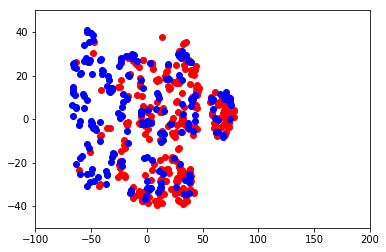

In [86]:
Y_exp = Y2[:size]
idx_not_survive = np.where(Y_exp==0)[0]
idx_survive = np.where(Y_exp==1)[0]


plt.xlim((-100,200))
plt.ylim((-50,50))
plt.scatter(X_tsne[idx_not_survive][:,0], X_tsne[idx_not_survive][:,1], color='red')
plt.scatter(X_tsne[idx_survive][-200:,0], X_tsne[idx_survive][-200:,1], color='blue')
plt.show()

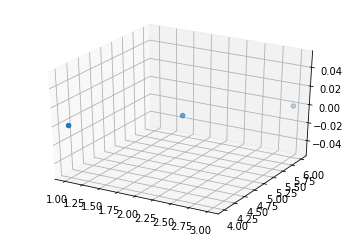

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([1,2,3],[4,5,6])
plt.show()

In [101]:
tsne = TSNE(n_components=3, init='pca', random_state=97, verbose=5)
size = 5000
X_tsne = tsne.fit_transform(X[:size])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.067s...
[t-SNE] Computed neighbors for 5000 samples in 2.077s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.415065
[t-SNE] Computed conditional probabilities in 0.227s
[t-SNE] Iteration 50: error = 52.8685150, gradient norm = 0.0144788 (50 iterations in 24.165s)
[t-SNE] Iteration 100: error = 55.9442863, gradient norm = 0.0097487 (50 iterations in 12.536s)
[t-SNE] Iteration 150: error = 57.3106384, gradient norm = 0.0083646 (50 iterations in 11.567s)
[t-SNE] Iteration 200: error = 58.3858414, gradient norm = 0.0030062 (50 iterations in 11.451s)
[t-SNE] Iteration 250: error = 58.2456474, gradient norm = 0.005

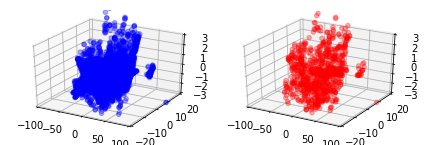

In [123]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Y_exp = Y2[:size]
idx_not_survive = np.where(Y_exp==0)[0]
idx_survive = np.where(Y_exp==1)[0]


fig = plt.figure()
ax1 = fig.add_subplot(221, projection='3d')
ax1.set_zlim(-3,3)
ax1.set_ylim(-20,20)
ax1.set_xlim(-100,100)

ax2 = fig.add_subplot(222, projection='3d')
ax2.set_zlim(-3,3)
ax2.set_ylim(-20,20)
ax2.set_xlim(-100,100)

ax2.scatter(xs=X_tsne[idx_not_survive][:,0], ys=X_tsne[idx_not_survive][:,1], zs=X_tsne[idx_not_survive][:,2], color='red')

ax1.scatter(xs=X_tsne[idx_survive][begin:,0], ys=X_tsne[idx_survive][begin:,1], zs=X_tsne[idx_survive][begin:,2],color='blue')
plt.tight_layout()
plt.show()
